In [1]:
import os
import librosa
import pandas as pd
from tqdm import tqdm

BASE_PATH = "../data/clean/LibriSpeech/train-clean-100"


In [2]:
data = []

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".trans.txt"):
            trans_path = os.path.join(root, file)
            with open(trans_path, "r") as f:
                lines = f.readlines()
                
                for line in lines:
                    parts = line.strip().split(" ", 1)
                    file_id = parts[0]
                    text = parts[1]
                    audio_path = os.path.join(root, file_id + ".flac")
                    if os.path.exists(audio_path):
                        data.append({
                            "file_id": file_id,
                            "audio_path": audio_path,
                            "text": text
                        })

df = pd.DataFrame(data)
df.head()


,file_id,audio_path,text
0,103-1240-0000,../data/clean/LibriSpeech/train-clean-100\103\...,CHAPTER ONE MISSUS RACHEL LYNDE IS SURPRISED M...
1,103-1240-0001,../data/clean/LibriSpeech/train-clean-100\103\...,THAT HAD ITS SOURCE AWAY BACK IN THE WOODS OF ...
2,103-1240-0002,../data/clean/LibriSpeech/train-clean-100\103\...,FOR NOT EVEN A BROOK COULD RUN PAST MISSUS RAC...
3,103-1240-0003,../data/clean/LibriSpeech/train-clean-100\103\...,AND THAT IF SHE NOTICED ANYTHING ODD OR OUT OF...
4,103-1240-0004,../data/clean/LibriSpeech/train-clean-100\103\...,BUT MISSUS RACHEL LYNDE WAS ONE OF THOSE CAPAB...


In [3]:
durations = []
sample_rates = []

for path in tqdm(df["audio_path"]):
    
    y, sr = librosa.load(path, sr=None)
    
    durations.append(len(y)/sr)
    sample_rates.append(sr)

df["duration"] = durations
df["sample_rate"] = sample_rates

df.head()


  0%|          | 0/28539 [00:00<?, ?it/s]c:\Users\Madesh\Desktop\Data Science Project\Noisy_Speech_Recognition\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 28539/28539 [06:57<00:00, 68.34it/s] 


,file_id,audio_path,text,duration,sample_rate
0,103-1240-0000,../data/clean/LibriSpeech/train-clean-100\103\...,CHAPTER ONE MISSUS RACHEL LYNDE IS SURPRISED M...,14.085,16000
1,103-1240-0001,../data/clean/LibriSpeech/train-clean-100\103\...,THAT HAD ITS SOURCE AWAY BACK IN THE WOODS OF ...,15.945,16000
2,103-1240-0002,../data/clean/LibriSpeech/train-clean-100\103\...,FOR NOT EVEN A BROOK COULD RUN PAST MISSUS RAC...,13.945,16000
3,103-1240-0003,../data/clean/LibriSpeech/train-clean-100\103\...,AND THAT IF SHE NOTICED ANYTHING ODD OR OUT OF...,14.710,16000
4,103-1240-0004,../data/clean/LibriSpeech/train-clean-100\103\...,BUT MISSUS RACHEL LYNDE WAS ONE OF THOSE CAPAB...,12.515,16000


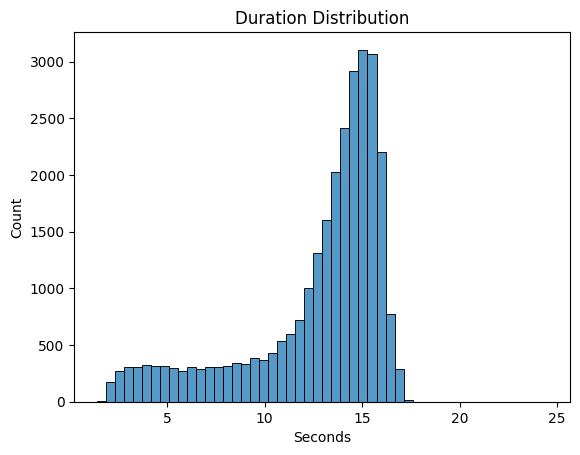

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
sns.histplot(df["duration"], bins=50)
plt.title("Duration Distribution")
plt.xlabel("Seconds")
plt.show()


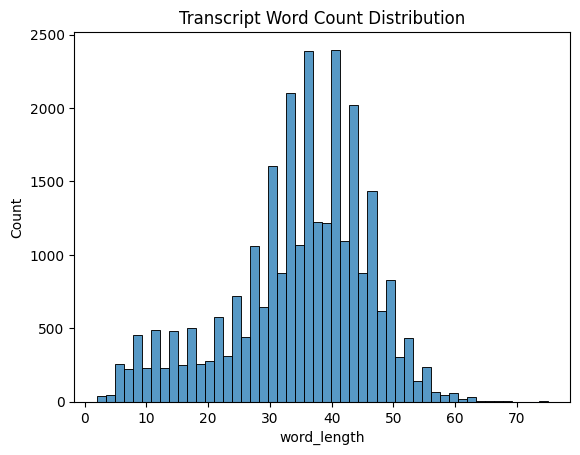

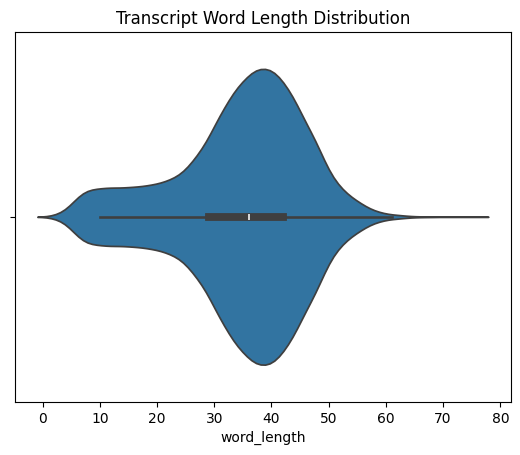

In [5]:
df["word_length"] = df["text"].apply(lambda x: len(x.split()))
df["char_length"] = df["text"].apply(len)

plt.figure()
sns.histplot(df["word_length"], bins=50)
plt.title("Transcript Word Count Distribution")
plt.show()


plt.figure()
sns.violinplot(x=df["word_length"])
plt.title("Transcript Word Length Distribution")
plt.show()



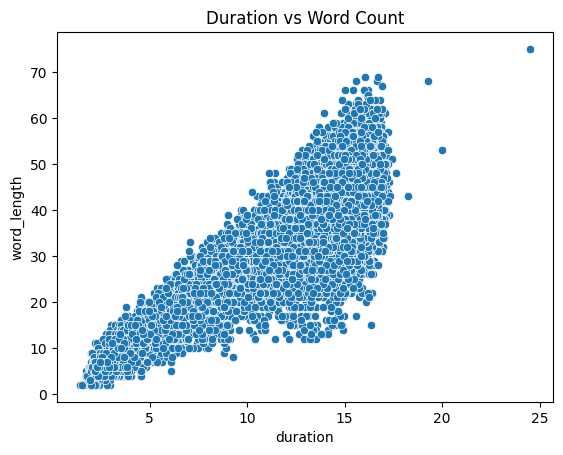

Correlation: 0.8583470688273508


In [6]:
plt.figure()
sns.scatterplot(x=df["duration"], y=df["word_length"])
plt.title("Duration vs Word Count")
plt.show()

print("Correlation:", df["duration"].corr(df["word_length"]))


In [7]:
sample_path = df.iloc[0]["audio_path"]

y, sr = librosa.load(sample_path, sr=None)


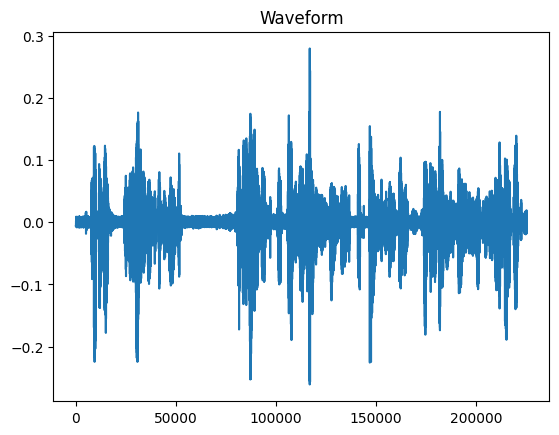

In [8]:
plt.figure()
plt.plot(y)
plt.title("Waveform")
plt.show()


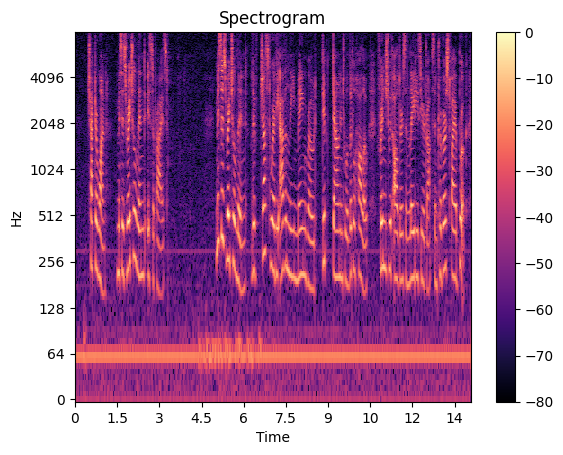

In [9]:
import numpy as np
import librosa.display

D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

plt.figure()
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()
plt.title("Spectrogram")
plt.show()


In [13]:
missing_audio = df[~df["audio_path"].apply(os.path.exists)]

print("Missing audio files:", len(missing_audio))
missing_audio.head()


Missing audio files: 0


,file_id,audio_path,text,duration,sample_rate,word_length,char_length


In [14]:
missing_text = df[df["text"].isnull()]

print("Missing transcripts:", len(missing_text))


Missing transcripts: 0


In [15]:
empty_text = df[df["text"].str.strip() == ""]

print("Empty transcripts:", len(empty_text))


Empty transcripts: 0


In [16]:
duplicates = df[df.duplicated("file_id")]

print("Duplicate file IDs:", len(duplicates))


Duplicate file IDs: 0


In [17]:
duplicate_text = df[df.duplicated("text")]

print("Duplicate transcripts:", len(duplicate_text))


Duplicate transcripts: 2


In [18]:
corrupted_files = []

for path in df["audio_path"][:1000]:  # check subset first
    try:
        y, sr = librosa.load(path, sr=None)
    except:
        corrupted_files.append(path)

print("Corrupted files:", len(corrupted_files))


Corrupted files: 0


In [19]:
short_audio = df[df["duration"] < 1]

print("Very short audio files:", len(short_audio))


Very short audio files: 0


In [20]:
long_audio = df[df["duration"] > 20]

print("Very long audio files:", len(long_audio))


Very long audio files: 1


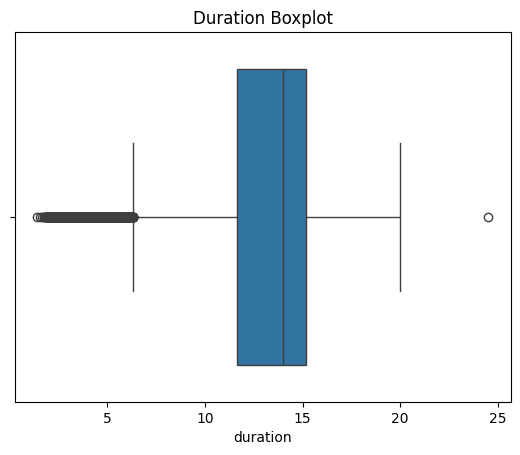

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure()
sns.boxplot(x=df["duration"])
plt.title("Duration Boxplot")
plt.show()


In [22]:
print(df["sample_rate"].value_counts())


sample_rate
16000    28539
Name: count, dtype: int64


In [23]:
df_wrong_sr = df[df["sample_rate"] != 16000]
print("Wrong SR files:", len(df_wrong_sr))


Wrong SR files: 0


In [24]:
import numpy as np

def silence_ratio(path, threshold=0.01):
    y, sr = librosa.load(path, sr=16000)
    silent = np.sum(np.abs(y) < threshold)
    return silent / len(y)


In [25]:
silence_values = []

for path in df["audio_path"][:300]:
    silence_values.append(silence_ratio(path))

df_silence = pd.DataFrame({"silence_ratio": silence_values})


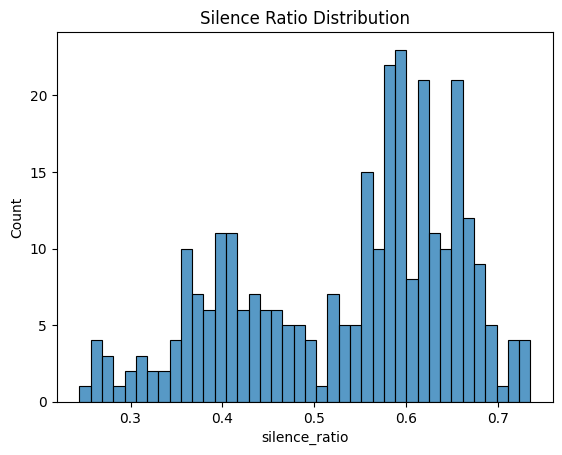

In [26]:
plt.figure()
sns.histplot(df_silence["silence_ratio"], bins=40)
plt.title("Silence Ratio Distribution")
plt.show()


In [27]:
def check_clipping(path):
    y, sr = librosa.load(path, sr=16000)
    return np.sum(np.abs(y) >= 0.99)

clipping_counts = []

for path in df["audio_path"][:300]:
    clipping_counts.append(check_clipping(path))

print("Clipping detected in:", sum([1 for c in clipping_counts if c > 0]), "files")


Clipping detected in: 6 files


In [28]:
import re

def has_special_chars(text):
    return bool(re.search(r"[^A-Z ']", text))

df["special_chars"] = df["text"].apply(has_special_chars)

print("Special character rows:", df["special_chars"].sum())


Special character rows: 0


In [29]:
very_long_text = df[df["word_length"] > 50]

print("Very long transcripts:", len(very_long_text))


Very long transcripts: 1345


In [30]:
def normalize_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z ']", "", text)
    return text

df["clean_text"] = df["text"].apply(normalize_text)


In [31]:
summary = {
    "Total samples": len(df),
    "Missing audio": len(missing_audio),
    "Empty transcripts": len(empty_text),
    "Short audio (<1s)": len(short_audio),
    "Long audio (>20s)": len(long_audio),
}

summary


{'Total samples': 28539,
 'Missing audio': 0,
 'Empty transcripts': 0,
 'Short audio (<1s)': 0,
 'Long audio (>20s)': 1}

In [32]:
total_hours = df["duration"].sum() / 3600
print("Total speech hours:", total_hours)


Total speech hours: 100.59087965277777
